# Part 1 ‐ Exploratory data analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
df=pd.read_json('logins.json')
%matplotlib inline

In [2]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df['login_time'].min()

Timestamp('1970-01-01 20:12:16')

In [4]:
df['login_time'].max()

Timestamp('1970-04-13 18:57:38')

In [5]:
df['count']=1

In [6]:
count_df=df.groupby(pd.Grouper(key='login_time', freq='15min')).sum().reset_index()
count_df.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


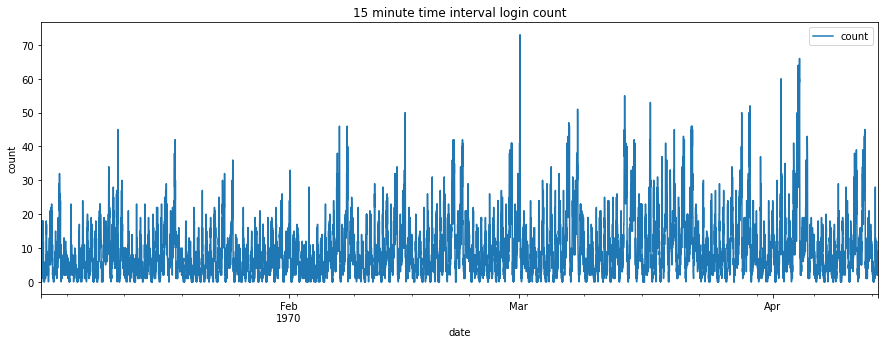

In [7]:
count_df.plot(x='login_time', y='count', figsize=(15, 5), \
              title='15 minute time interval login count', \
              xlabel='date', ylabel='count')
plt.show()

So, after analyzing the 15 minute intervals we can assume that there is some weekday and hourly seasonality. But before visualizing them let's create some new columns for time, day and weekday.

In [8]:
df['hour']=df['login_time'].dt.hour
df['day']=df['login_time'].dt.day
df['weekday']=df['login_time'].dt.weekday
df.head()

,login_time,count,hour,day,weekday
0,1970-01-01 20:13:18,1,20,1,3
1,1970-01-01 20:16:10,1,20,1,3
2,1970-01-01 20:16:37,1,20,1,3
3,1970-01-01 20:16:36,1,20,1,3
4,1970-01-01 20:26:21,1,20,1,3


Let's start by plotting daily seasonality in one month period.

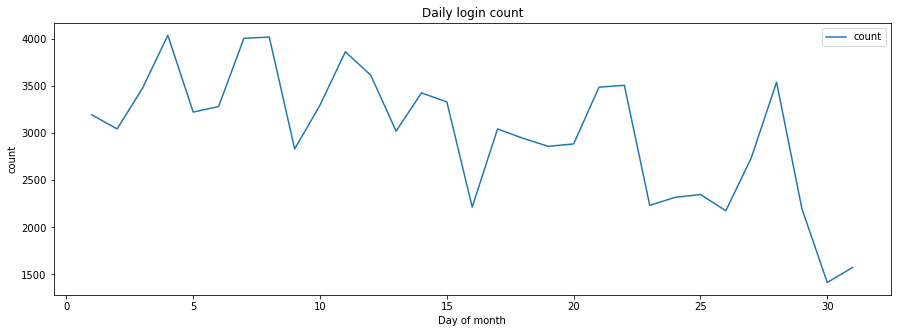

In [9]:
daily_df=df.groupby('day')['count'].sum().reset_index()
daily_df.plot(x='day', y='count', figsize=(15, 5), \
              title='Daily login count', \
              xlabel='Day of month', ylabel='count')
plt.show()

We can notice some downward trend of logins over the month.

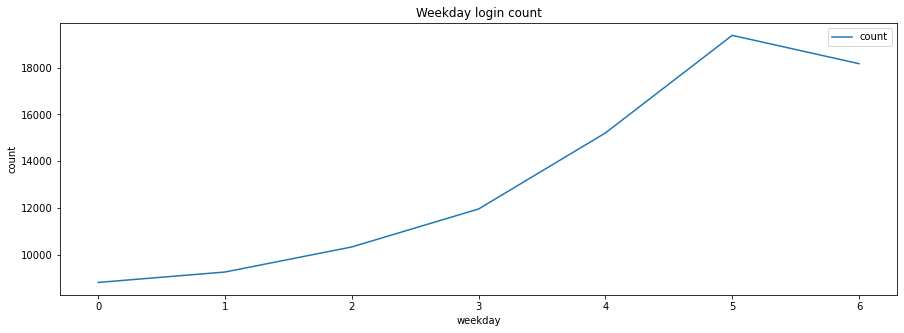

In [10]:
weekday_df=df.groupby('weekday')['count'].sum().reset_index()
weekday_df.plot(x='weekday', y='count', figsize=(15, 5), \
              title='Weekday login count', \
              xlabel='weekday', ylabel='count')
plt.show()

Now we can clearly see that we have few times more logins on weekends than on weekdays. And the number starts to significantly increase starting from Thursday thru Saturday. On Sundays we are having a slight decrease in logins compared to Saturdays.

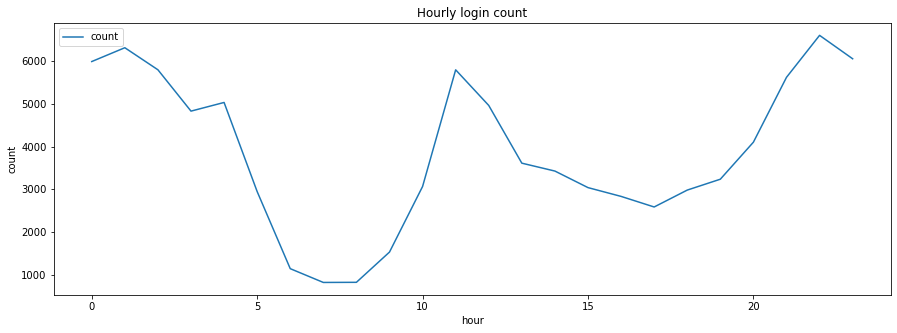

In [11]:
hourly_df=df.groupby('hour')['count'].sum().reset_index()
hourly_df.plot(x='hour', y='count', figsize=(15, 5), \
              title='Hourly login count', \
              xlabel='hour', ylabel='count')
plt.show()

Starting from 7 am, which is the time of the day when we have the lowest number of logins, more users enter the website until 11 am. This is the first peak hour of the day in terms of logins. After 11 am the login count gradually goes down until 4 pm. And then it goes up reaching its second peak value around 11 pm and stays there until 1am.

# Part 2 ‐ Experiment and metrics design

#### 1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities and why would you choose this metric? </br>

As the key measure of success, I would choose the driver's average hourly earnings. </br>

#### 2) Describe a practical experiment you would design to compare the effectiveness of theproposed change in relation to the key measure of success. </br>

We can use A/B testing for this experiment. We'd split our drivers in both cities into 2 equal-sized groups. And for the first groups in both cities, we would reimburse all toll costs. For the second groups, the toll costs would remain the same. After two weeks we'd compare the driver's average hourly earnings for both groups in both cities. And then we'd calculate the difference in hourly earnings for both groups in each city. </br>
If the experiment's p-value is greater than 5% then the results are statistically significant and reimbursing the toll costs has a positive impact on drivers' hourly earnings. But we need to take into consideration some factors before making the final recommendations: </br>
1) Reimbursing the toll costs is an additional expense for the company. So we need to subtract the hourly toll costs for each driver from the first groups of the experiment. </br>
2) We also need to pay attention to drivers' working hours. Different active times of the day in 2 cities might cause the drivers to drive longer hours which can also increase the company's revenue.

# Part 3 ‐ Predictive modeling

In [12]:
ult_df=pd.read_json('ultimate_data_challenge.json')
ult_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [13]:
max_date=ult_df['last_trip_date'].max()
max_date

'2014-07-01'

First of all let's create our target column which shows if the customer has retained or not.

In [14]:
ult_df['retention']=0
ult_df.loc[ult_df['last_trip_date']>='2014-06-01', 'retention']=1
ult_df['retention'].value_counts(normalize=True)

0    0.62392
1    0.37608
Name: retention, dtype: float64

So, it appears that 38% of the customers who signed up in January still use our services. Now let's do some data cleaning.

In [15]:
ult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
 12  retention               50000 non-null  int64  
dtypes: bool(1), float64(6), int64(2), object(4)
memory usage: 4.6+ MB


We have some missing values in 3 columns. Let's start with avg_rating_of_driver and avg_rating_by_driver.

In [16]:
ult_df[ult_df['avg_rating_of_driver'].isna()]['retention'].value_counts(normalize=True)

0    0.799064
1    0.200936
Name: retention, dtype: float64

In [17]:
ult_df[ult_df['avg_rating_by_driver'].isna()]['retention'].value_counts(normalize=True)

0    0.820896
1    0.179104
Name: retention, dtype: float64

It appears that there is some relationship between the rows with null values in these columns and the retention rate. While 38% of all customers still use the service, only 20% and 18% with no driver and no customer rating users respectively are still our customers. Let's fill those rows with 0s.

In [18]:
ult_df['avg_rating_of_driver'].fillna(0, inplace=True)
ult_df['avg_rating_by_driver'].fillna(0, inplace=True)

Now let's have a look at the 'phone' column.

In [19]:
ult_df['phone'].value_counts(dropna=False)

iPhone     34582
Android    15022
None         396
Name: phone, dtype: int64

In [20]:
ult_df[ult_df['phone'].isna()]['retention'].value_counts(normalize=True)

0    0.664141
1    0.335859
Name: retention, dtype: float64

The distribution of retention rates is the same in case of customers' phone type and less than 1% of values is only missing. So we can simply impute the missing values with the most frequent value ('iPhone').

In [21]:
ult_df['phone'].fillna('iPhone', inplace=True)

Now let's take a look at our numeric columns.

In [22]:
ult_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retention
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,3.854082,1.074764,8.849536,60.926084,5.796827,4.758950,0.376080
std,3.792684,1.788881,0.222336,19.958811,37.081503,5.707357,0.538617,0.484405
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


The distributions of all values look good besides the 'trips_in_first_30_days' column. One of the customers has 125 trips in the first month of using the service. 

In [23]:
ult_df[ult_df['trips_in_first_30_days']>60]['trips_in_first_30_days'].value_counts()

73     1
71     1
125    1
63     1
Name: trips_in_first_30_days, dtype: int64

In [24]:
ult_df[ult_df['trips_in_first_30_days']==125]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8,1


The customer took 4 trips per day on average in the first month, which is quite impressive number, but there is no reason to exclude this row from the data. It is an outlier for our future model but it can hardly affect the model performance considering the fact that we have 50.000 customers info in total.

For the 'ultimate_black_user' column have boolean values, let's convert them to 0s and 1s so that we can use them in the model.

In [25]:
ult_df['ultimate_black_user']=ult_df['ultimate_black_user'].map({True:1, False:0})
ult_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0


Let's check for duplicate values.

In [26]:
ult_df.duplicated().sum()

8

We have 8 duplicate rows, let's drop them.

In [27]:
ult_df.drop_duplicates(inplace=True)

Now let's do some exploratory data analysis.

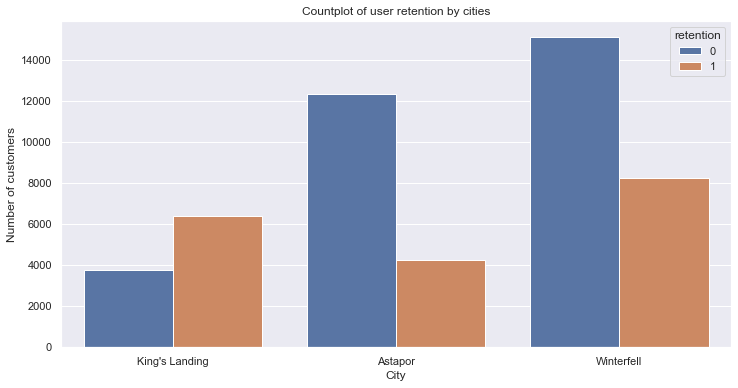

In [28]:
sns.set(rc={'figure.figsize':(12,6)})
sns.countplot(data=ult_df, x='city', hue='retention').set(title='Countplot of user retention by cities')
plt.xlabel('City')
plt.ylabel('Number of customers')
plt.show()

We can see that most of the King's Landing customers who signed up in January are still active. On the other hand around 25% of Astapor and  35% of Winterfell customers remained active after signing up.

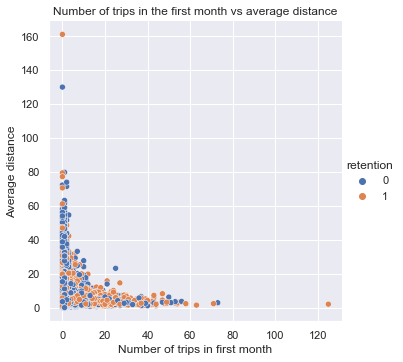

In [29]:
sns.set(rc={'figure.figsize':(12,6)})
sns.relplot(data=ult_df, x='trips_in_first_30_days', y='avg_dist', hue='retention').set(title='Number of trips in the first month vs average distance')
plt.xlabel('Number of trips in first month')
plt.ylabel('Average distance')
plt.show()

As we can see there is some strong inverse correlation between number of trips and average distance in the first month and most of the active customers are those who take shorter trips.

Before building our model let's do some preprocessing: drop the date columns, create dummy variables for our categorical features and scale the numeric columns.

In [30]:
model_df=ult_df.drop(columns=['signup_date', 'last_trip_date'])
model_df = pd.get_dummies(data = model_df, columns = ['city', 'phone'])
model_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


Now let's scale our data and split it into training and test sets.

In [31]:
X=model_df.drop(columns='retention')
y=model_df['retention']

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X=pd.DataFrame(scaled_X, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

Let's create our first model. We will use logistic regression to predict the binary outcome of last month's (June) retention.

In [32]:
log_reg=LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred=log_reg.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Model Accuracy: ', accuracy)

Model Accuracy:  0.718971897189719


The accuracy of 72% on test set is not a bad result but let's try another algorithm - XGBoost.

In [33]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test, y_test)))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.79


We got much better results with XGBoost, now let's have a look at our classification report

In [34]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      6254
           1       0.74      0.67      0.70      3745

    accuracy                           0.79      9999
   macro avg       0.78      0.76      0.77      9999
weighted avg       0.79      0.79      0.79      9999



So 73% of our model's predicted active customers are actually active and it is able to predict 67% of all active customers. We got better results for inactive customers.
Now, let’s see which features our model exactly used from the dataset and which were the most important ones.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

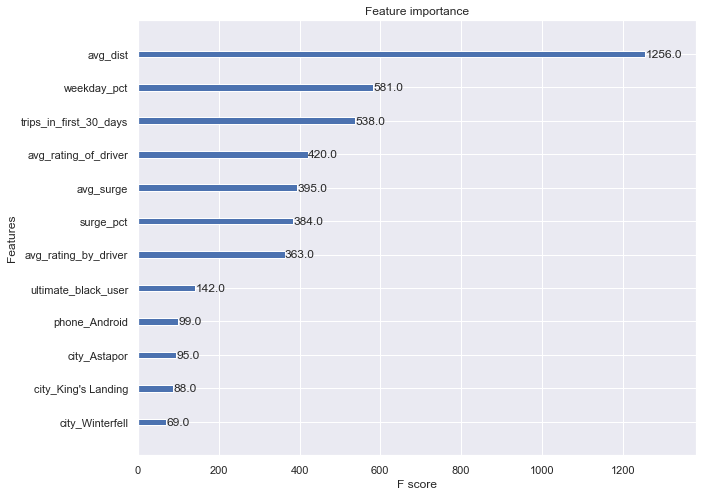

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

It appears that 3 most important features for retention prediction are: the average trip distance, the user’s weekday trips percentage and number of trips taken in first 30 days. </br>
So, in order to improve its long term rider retention Ultimate can update it's pricing strategy and create promotions to make longer distance and weekday trips more affordable, give discounts to new customers in order to maximize their trips in first 30 days. 